In [16]:
import os
import cv2
import math
import pickle
import random
import numpy as np
import pandas as pd
from pathlib import Path
from threading import Thread
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# get smoky-mountain-data-comp folder
HOME_DIR = str(Path().cwd().parent)

# get the sam data folder
SAM_FOLDER = "seg_from_SAM"

# load the spreadsheet into the kernel
SHEET_DATA = pd.read_excel(f"{HOME_DIR}/data.xlsx")
SHEET_DATA.head()

,filename,treatment,block,row,position,genotype
0,EB00CEE6-848F-4E2A-9A56-C0CD83D55630.jpg,D,1.0,8.0,32.0,BESC-34
1,5AF900F9-D701-4994-95AC-2352420BF18F.jpg,C,1.0,10.0,12.0,"**BESC-417_LM**,core"
2,F7D01515-92CA-4AF5-9BD9-3A4CD99EDF42.jpg,C,2.0,3.0,40.0,BESC-468
3,9117861B-2D2B-4EA8-94B1-D0A862914398.jpg,C,2.0,6.0,54.0,BESC-28_LM
4,D1B282CF-2A10-4458-9E3A-FE08E065A3D6.jpg,C,1.0,24.0,22.0,"**LILD-26-5_LM**,core"


Functions and Type Declarations

In [8]:
cv2.Image = np.ndarray
cv2.Contour = np.ndarray

# shows an image on ipynb
def imshow(img: np.ndarray) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# get a random filename from within the sheet
def get_random_filename() -> str:
    return SHEET_DATA['filename'][random.randint(0, len(SHEET_DATA)-1)]

# display filename and image, and get image going to filename
def get_image(filename: str = None, show: bool = True):
    if filename is None:
        filename = get_random_filename()
    img = cv2.imread(f"{HOME_DIR}/dataset/{filename}")
    if show:
        print(filename)
        imshow(img)
    return img

def draw_contours(contours: list[cv2.Contour], img: cv2.Image, mode: str = "random") -> cv2.Image:
    """ Draw contours onto an image with random colors """
    draw_img = img.copy()
    for contour in contours:
        if mode == "random":
            color = tuple(random.randint(150, 255) for _ in range(3))
        elif mode == "red": 
            color = (0, 0, 255)
        elif mode == "blue":
            color = (255, 0, 0)
        elif mode == "green":
            color = (0, 255, 0)
        else:
            raise Exception("Invalid color mode.")
        draw_img = cv2.drawContours(draw_img, [contour], -1, color, 5)
    return draw_img

# easy access grayscale function
def grayscale(img: cv2.Image) -> cv2.Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Get the contours from the segmented images

2728FC13-5EE5-4979-B800-8748EF0FF6E1.jpg


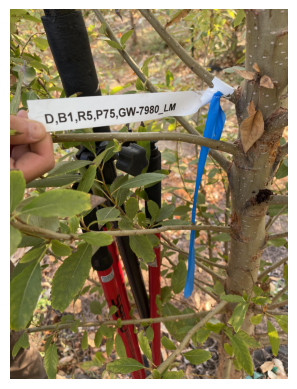

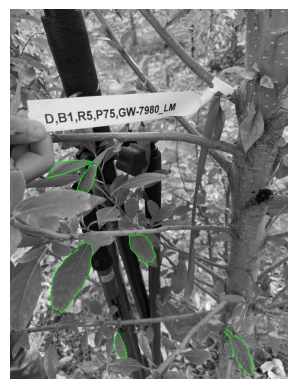

In [44]:
def load_contours(img: cv2.Image, mask: cv2.Image, show: bool = False) -> list[cv2.Contour]:
    
    # find contours from the mask
    edged = cv2.Canny(mask, threshold1=0, threshold2=0)
    contours = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    # filter away ones that are too small
    contours = [*filter(lambda cnt: cv2.contourArea(cnt) > float(np.prod(img.shape[:2])) / 1000, contours)]

    if show:
        drawn_contours = draw_contours(contours, cv2.cvtColor(grayscale(img), cv2.COLOR_GRAY2BGR), mode="green")
        imshow(drawn_contours)
    
    return contours

filename = random.choice(os.listdir(f"{SAM_FOLDER}/images"))
img = get_image(filename)
mask = cv2.imread(f"{SAM_FOLDER}/images/{filename}", cv2.IMREAD_GRAYSCALE)

_ = load_contours(img, mask, show=True)

Get the features from the contour

In [51]:
def get_features_mask(contour: cv2.Contour, img: cv2.Image) -> dict[str, float]:

    # get contour moments
    moments = cv2.HuMoments(cv2.moments(contour))
    adjusted_moments = map(lambda x: -math.copysign(1.0, x) * math.log10(abs(x)), [*moments])
    moment_dict = {f'h{i}': m for i, m in enumerate(adjusted_moments)}

    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)

    # the idea here is that ratios are more important than the values themselevs
    # get ratio of area to bounding rect, perimeter, and bounding hull
    area_rect_ratio = area / (w * h)
    area_peri_ratio = area / cv2.arcLength(contour, True) ** 2    # might make it too sensitive :O
    convex_area_ratio = area / cv2.contourArea(cv2.convexHull(contour))

    # ratio of area covered by fit ellipse to contour
    el_mask, cnt_mask = [np.zeros((y+h*3, x+w*3)) for _ in range(2)]
    ellipse = cv2.fitEllipse(contour)
    ellipse_area = float(np.prod(ellipse[1])) * math.pi / 4
    el_mask = cv2.ellipse(el_mask, ellipse, 100, thickness=cv2.FILLED)
    cnt_mask = cv2.drawContours(cnt_mask, [contour], -1, 100, cv2.FILLED)
    total_mask = cv2.threshold((el_mask + cnt_mask).astype(np.uint8), 150, 255, 0)[1]
    merged_contours = cv2.findContours(total_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    total_merged_area = sum(map(cv2.contourArea, merged_contours))

    # ratio of area (in contour and ellipse) to interesct with bounding ellipse
    area_intersect_ratio = total_merged_area / area
    area_ellipse_intersect_ratio = total_merged_area / ellipse_area

    # get average color - in hsv
    drawn_contour = cv2.drawContours(np.zeros(img.shape[:2], dtype=np.uint8), [contour], -1, (255), cv2.FILLED)
    mean = cv2.mean(img, mask=drawn_contour)
    avg_colors = {
        label: col_val for label, col_val
        in zip(['col_h', 'col_s', 'col_v'], mean)
    }

    # get ratio of contour area to area of whole image
    area_imagearea_ratio = area / float(np.prod(img.shape[:2]))

    # return extracted features
    return {
        'area_peri': area_peri_ratio,
        'area_rect': area_rect_ratio,
        'area_convex': convex_area_ratio,
        'area_elli_inter': area_intersect_ratio,
        'ellipse_elli_inter': area_ellipse_intersect_ratio,
        'area_image': area_imagearea_ratio
    } | moment_dict | avg_colors

Train model subjectively

In [52]:
IMAGE_COUNT = 20

class FeatureThread(Thread):
    def __init__(self, contour: cv2.Contour, img: cv2.Image):
        Thread.__init__(self)
        self.contour = contour
        self.img = img
        self.features = None
    def run(self):
        self.features = get_features_mask(self.contour, self.img)

data = []
files = {*random.choices(os.listdir(f"{SAM_FOLDER}/images"), k=IMAGE_COUNT)}
try:
    for filename in files:

        # get the image and the leaf contours
        img = get_image(filename, show=False)
        mask = cv2.imread(f"{SAM_FOLDER}/images/{filename}", cv2.IMREAD_GRAYSCALE)
        contours = load_contours(img, mask)

        # go through each leaf
        for contour in contours:

            # start a thread for feature extraction
            thread = FeatureThread(contour, img)
            thread.start()

            # generate mask of only the leaf being shown
            mask = cv2.drawContours(np.zeros(img.shape[:2], dtype=np.uint8), [contour], -1, 255, cv2.FILLED)
            masked_img = cv2.bitwise_and(img, img, mask=mask)
            imshow(masked_img)
            
            # wait for thread to run during input, join thread, and take data
            is_leaf = input("Is this image a proper leaf?")
            thread.join()
            data.append(thread.features | {'is_leaf': is_leaf})
            clear_output()

# store data regardless of exit scenario
finally:
    df = pd.DataFrame(data)
    print(df.head())
    if SAM_FOLDER not in os.listdir():
        os.mkdir(SAM_FOLDER)
    df.to_csv(f'{SAM_FOLDER}/data.csv', index=False)

   area_peri  area_rect  area_convex  area_elli_inter  ellipse_elli_inter  \
0   0.018395   0.392051     0.890162         0.939052            0.847923   
1   0.015241   0.366944     0.914040         0.972218            0.894697   
2   0.047668   0.644393     0.975748         0.954556            0.688512   
3   0.029525   0.418440     0.961337         0.942253            0.899414   
4   0.021600   0.641911     0.927822         0.976997            0.917958   

   area_image        h0        h1        h2        h3        h4        h5  \
0    0.014922  0.462408  1.045062  2.559386  2.843302  5.547336  3.427662   
1    0.005309  0.394056  0.864398  3.059274  3.671945  7.154958  4.522390   
2    0.003615  0.691052  1.996143  2.622750  3.818163  7.089985  4.948842   
3    0.004737  0.473022  1.064109  2.660326  2.933405  5.732173  3.495620   
4    0.002227  0.507147  1.149858  3.333038  3.564021  7.013060  4.151063   

         h6       col_h       col_s       col_v is_leaf  
0  6.499545  129

In [13]:
# process the data - balance tje dataset by removing extra non-leaves
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df_leaf = df[df['is_leaf'] == 'y']
    df_no_leaf = df[df['is_leaf'] == 'n']
    n = len(df_no_leaf) - len(df_leaf)
    if n == 0: return df
    elif n > 0:
        drop_indeces = np.random.choice(df_no_leaf.index, n, replace=False)
        return pd.concat([df_no_leaf.drop(drop_indeces), df_leaf], ignore_index=True)
    else:
        drop_indeces = np.random.choice(df_leaf.index, n, replace=False)
        return pd.concat([df_leaf.drop(drop_indeces), df_no_leaf], ignore_index=True)

# get training and testing data
df = preprocess(pd.read_csv(f"{SAM_FOLDER}/data.csv"))
y_col = [*map(lambda x: x.lower() == 'y', df.pop('is_leaf'))]
X_train, X_test, y_train, y_test = train_test_split(df, y_col, test_size=0.3)

# adjust the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# train the model and save
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)
with open(f"{SAM_FOLDER}/model.pkl", "wb") as f:
    pickle.dump(model, f)
with open(f"{SAM_FOLDER}/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")

Accuracy: 100.00%


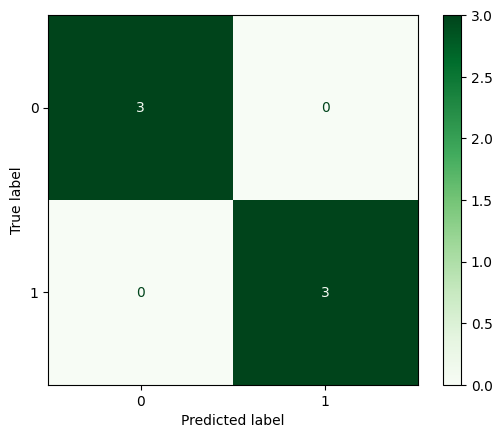

In [18]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Greens")
plt.show()